# Workshop Tutorial 1: Practical Apricot Usage

Welcome to a tutorial on how to reduce redundancy in massive data sets using submodular optimization! In this tutorial, we will explore submodular optimization at a high level and see how it can be used to select representative subsets of data; these subsets can then be used on their own, such as to create a highlight reel for an album, or to create smaller training sets for machine learning models that achieve similar performance in a fraction of the time. Although submodular optimization is as general-purpose as convex optimization, this tutorial will focus on using basic optimization algorithms on two main functions: a feature-based function, and facility location functions. Finally, this tutorial will focus on practical usage of apricot. Please see the other tutorials for more of the theory behind how these functions work. 

Let's get started!

In [1]:
%pylab inline
import seaborn
seaborn.set_style('whitegrid')

from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


## Feature-based Selection

A simple class of submodular functions are the feature-based ones. At a high level, feature-based functions are those that maximize diversity in the observed feature values themselves. This property means that they work well in settings where each feature represents some quality of the data and higher values mean that the example has more of that value: for instance, when vectorizing text data, each feature might represent a word and the value would be the number of times that the word appears in the document.

More formally, feature-based functions take the form

\begin{equation}
f(X) = \sum\limits_{u \in U} w_{u} \phi_{u} \left( \sum\limits_{x \in X} m_{u}(x) \right)
\end{equation}
where $x$ is a single example, $X$ is the set of all examples, $u$ is a single feature, $U$ is the set of all features, $w$ is a weight foe each feature, and $\phi$ is a saturating concave function such as log or sqrt.

### 20 newsgroups

Let's start off with some text data. Below, some code is provided to download a shuffled version of the 20 newsgroups data set, which contains articles and labels for 20 topics. However, as we can see, the downloaded text is not in a convenient featurized form that can be used by machine learning models.

In [2]:
from sklearn.datasets import fetch_20newsgroups

train_data = fetch_20newsgroups(subset='train', random_state=0, shuffle=True)
train_data.data[2]

"From: jeffp@vetmed.wsu.edu (Jeff Parke)\nSubject: Re: Lyme vaccine\nOrganization: College of Veterinary Medicine WSU\nX-Newsreader: TIN [version 1.1 PL9]\nLines: 13\n\nkathleen richards (kilty@ucrengr) wrote:\n\n> If you have time to type it in I'd love to have the reference for that\n> paper!  thanks!\n\nExperimental Lyme Disease in Dogs Produces Arthritis and Persistant Infection,\nThe Journal of Infectious Diseases, March 1993, 167:651-664\n\n--\nJeff Parke <jeffp@pgavin1.vetmed.wsu.edu>\nalso:   jeffp@WSUVM1.bitnet    AOL: JeffParke\nWashington State University College of Veterinary Medicine class of 1994\nPullman, WA  99164-7012\n"

Processing this to get rid of the weird characters like "\n" and converting it to a vectorized form is not really the point of this tutorial, so let's use sklearn's built-in vectorizer to get a clean feature matrix to operate on. Please fill in the below cells.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_data.data)
X_train.shape

(11314, 1000)

Let's take a look at how dense that data is. We can do this by creating a heatmap where each red dot represents that the feature hasa non-zero value. If you implemented the above code correctly you should get a density of 0.08395.

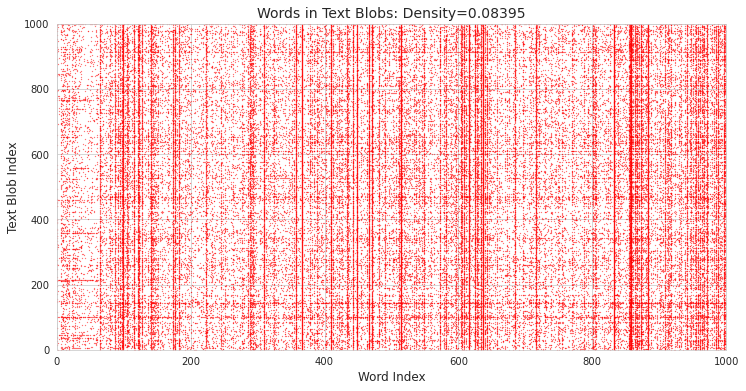

In [5]:
i = 1000

X_random_block = X_train[:i].toarray()
random_density = (X_random_block != 0).mean()

plt.figure(figsize=(12, 6))
plt.scatter(*numpy.where(X_random_block.T[:i] != 0), c='r', s=0.05)
plt.xlim(0, i)
plt.ylim(0, i)

plt.title("Words in Text Blobs: Density={:4.4}".format(random_density), fontsize=14)
plt.xlabel("Word Index", fontsize=12)
plt.ylabel("Text Blob Index", fontsize=12)
plt.show()

In [7]:
X_train

<11314x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 963475 stored elements in Compressed Sparse Row format>

In [6]:
X_random_block

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 2, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

The above heat map is made up of the first 1000 entries in the data set after shuffling. It doesn't seem particularly dense; fewer than 10% of the values in the matrix are positive. This may not be particularly problematic when restricting to 1000 features, but since more features generally means more accuracy in this setting, is there a way to ensure that our subset sees a higher percentage of the features?

Well, choosing examples that exhibit values in a diverse set of features is exactly what submodular optimization and feature based functions are good at. We can define a feature-based function easily using apricot, choose an equal sized subset of examples using submodular optimization, and re-visualize the chosen examples.

Fill in the next code block, using a feature-based selector to choose 1000 samples with everything else set to the default parameters. You can also set `verbose=True` to see a progress bar during selection. Note that, while apricot can operate on sparse matrices, you might need to use the `toarray()` method to convert a sparse array to a dense array for the subsequent visualization step.

In [11]:
from apricot import FeatureBasedSelection

selector = FeatureBasedSelection(1000, verbose=True)

X_submodular_block = selector.fit_transform(X_train).toarray()

100%|██████████| 1.00k/1.00k [00:01<00:00, 725it/s]


In [10]:
help(FeatureBasedSelection)

Help on class FeatureBasedSelection in module apricot.functions.featureBased:

class FeatureBasedSelection(apricot.functions.base.BaseSelection)
 |  FeatureBasedSelection(n_samples, concave_func='sqrt', initial_subset=None, optimizer='two-stage', optimizer_kwds={}, reservoir=None, max_reservoir_size=1000, n_jobs=1, random_state=None, verbose=False)
 |  
 |  A selector based off a feature based submodular function.
 |  
 |  Feature-based functions are those that operate on the feature values of 
 |  examples directly, rather than on a similarity matrix (or graph) derived 
 |  from those features, as graph-based functions do. Because these functions 
 |  do not require calculating and storing a :math:`\mathcal{O}(n^{2})` sized 
 |  matrix of similarities, they can easily scale to data sets with millions of 
 |  examples. 
 |  
 |  .. note:: 
 |          All values in your data must be positive for this selection to work.
 |  
 |  The general form of a feature-based function is:
 |  
 |  

Now that you've selected the examples, we can visualize the block in the same way that we visualized the randomly selected examples. If you implemented the selector correctly, you should get a density of 0.2103. Visually, the heatmap should also look significantly more red. This is because we are intentionally choosing examples that have many non-zero values, i.e., rows that would have red in a lot of columns.

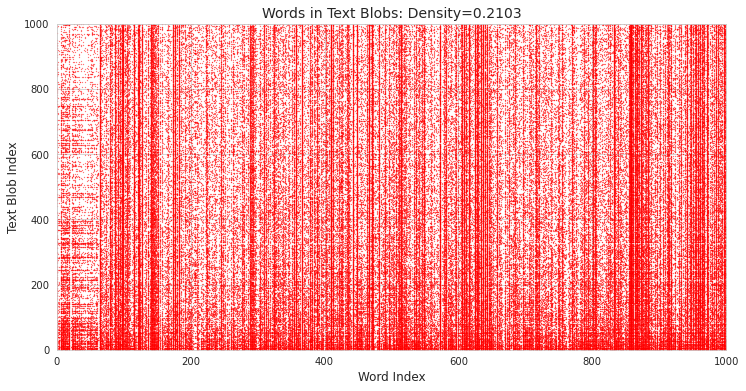

In [12]:
submodular_density = (X_submodular_block != 0).mean()

plt.figure(figsize=(12, 6))
plt.scatter(*numpy.where(X_submodular_block.T[:i] != 0), c='r', s=0.05)
plt.xlim(0, i)
plt.ylim(0, i)

plt.title("Words in Text Blobs: Density={:4.4}".format(submodular_density), fontsize=14)
plt.xlabel("Word Index", fontsize=12)
plt.ylabel("Text Blob Index", fontsize=12)
plt.show()

Next, we can take a look at the number of words that are observed at least once as we select more and more examples, either randomly, or using submodular optimization. If your implementation of selecting a subset of examples using apricot is correct you should see that a larger number of words are observed earlier in the selection process when submodular optimization is used. You do not need to do anything here. 

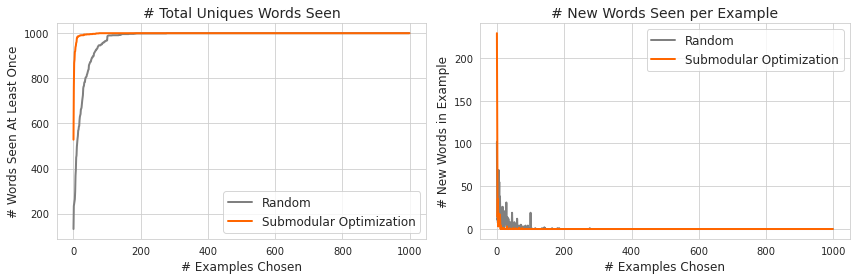

In [13]:
random_seen_words = (numpy.cumsum(X_random_block, axis=0) > 0).sum(axis=1)
submodular_seen_words = (numpy.cumsum(X_submodular_block, axis=0) > 0).sum(axis=1)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("# Total Uniques Words Seen", fontsize=14)
plt.plot(random_seen_words, color='0.5', linewidth=2, label="Random")
plt.plot(submodular_seen_words, color='#FF6600', linewidth=2, label="Submodular Optimization")
plt.xlabel("# Examples Chosen", fontsize=12)
plt.ylabel("# Words Seen At Least Once", fontsize=12)
plt.legend(fontsize=12)

plt.subplot(122)
plt.title("# New Words Seen per Example", fontsize=14)
plt.plot(numpy.diff(random_seen_words), color='0.5', linewidth=2, label="Random")
plt.plot(numpy.diff(submodular_seen_words), color='#FF6600', linewidth=2, label="Submodular Optimization")
plt.xlabel("# Examples Chosen", fontsize=12)
plt.ylabel("# New Words in Example", fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

Next, we're going to move on to the primary goal of apricot: choosing subsets for training machine learning models. Unfortunately, this is not always straightforward. As an example, we are going to consider classifying a subset of classes from the 20 newsgroups data set. Here are the classes.

In [14]:
fetch_20newsgroups(subset="train").target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

As an initial example, we will focus on two classes that are somewhat related conceptually but will likely have distinct vocabularies. We will use the TF-IDF vectorizer instead of the count vectorizer because TF-IDF is a straightforward way to downweight words that appear in many articles and to upweight words that are somewhat rare and more likely to be topic-specific. Please fill in the below code involving processing the training and test data properly.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

categories = ['sci.med', 'sci.space']

train_data = fetch_20newsgroups(subset='train', categories=categories, random_state=0, shuffle=True)
test_data = fetch_20newsgroups(subset='test', categories=categories, random_state=0)

vectorizer = TfidfVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_data.data)
X_test = vectorizer.transform(test_data.data)

y_train = train_data.target
y_test = test_data.target

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1187, 1000), (790, 1000), (1187,), (790,))

Next, use a feature-based function to select 1000 examples from the training data. 1000 examples is almost all of the data, but because the selection process is greedy we can use it to rank most of the data and then choose increasingly large subsets to train the model.

Note: feature based selectors work very quickly

In [18]:
selector = FeatureBasedSelection(1000, verbose=True)
selector.fit(X_train)

100%|██████████| 1.00k/1.00k [00:01<00:00, 730it/s]


Now, let's train a SGG classifier on subsets of increasing size and compare to ten draws of similarly sized random subsets. Please fill in the below code, keeping in mind that the `selector.ranking` attribute contains a ranking of indices from the original data set. For example, if the first element was `10`, that would mean that `X_train[10]` was the first element chosen by the greedy optimization process.

100%|██████████| 100/100 [00:03<00:00, 30.90it/s]


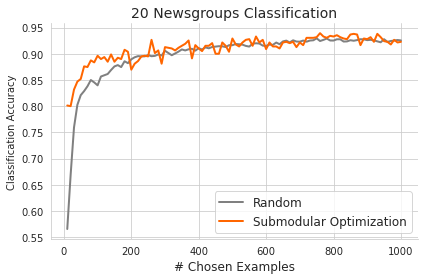

In [21]:
model = SGDClassifier(random_state=0)
counts = numpy.arange(10, 1001, 10)

random_idxs = numpy.array([numpy.random.choice(X_train.shape[0], replace=False, size=1000) for i in range(10)])
random_accuracies, submodular_accuracies = [], []

for count in tqdm(counts):
    idxs = selector.ranking[:count] # greedily selected ranking of element
    
    model.fit(X_train[idxs], y_train[idxs]) 

    y_hat = model.predict(X_test)
    acc = (y_hat == y_test).mean()
    submodular_accuracies.append(acc)
    
    accs = []
    for i in range(10):
        r_idxs = random_idxs[i, :count]
        
        # each time fit is called it re-inits parameters, so there is no leakage from the last fit
        model.fit(X_train[r_idxs], y_train[r_idxs])

        y_hat = model.predict(X_test)
        acc = (y_hat == y_test).mean()
        accs.append(acc)
    
    random_accuracies.append(accs)

plt.title("20 Newsgroups Classification", fontsize=14)
plt.plot(counts, numpy.mean(random_accuracies, axis=1), color='0.5', linewidth=2, label="Random")
plt.plot(counts, submodular_accuracies, color='#FF6600', linewidth=2, label="Submodular Optimization")

plt.xlabel("# Chosen Examples", fontsize=12)
plt.ylabel("Classification Accuracy")
plt.legend(loc=4, fontsize=12)

seaborn.despine()
plt.tight_layout()
plt.show()

Note: the graph above shows that using submodular optimization gets to higher accuracy with a much maller number of examples

Looks like we can get almost the same performance with just 100 examples (~93% with submodular optimization and ~85% with random selection) as we could with the full set of 1000 examples. It is worth noting that there is a lot of variance when the number of examples chosen is very small, but that performance picks up pretty quickly. If you're not seeing these trends, it's possible that you implemented something incorrectly.

If you'd like to explore apricot's abilities more broadly, try out the above cells using different sets of categories from the 20 newsgroups corpus and different types of classifiers. 

### A Warning: Gaussian Blobs

Unfortunately, not all data is amenable to feature-based functions. Specifically, data sets where the features don't follow the semantics that are assumed, i.e., non-negative and a higher value conveys some notion of having "more" of some feature. If you have features like coordinates or embeddings from a pre-trained model or projections from a method like tSNE or UMAP, they may not work as you'd like.

Here, we will look at using data drawn from random Gaussian blobs.

In [22]:
from sklearn.datasets import make_blobs

numpy.random.seed(0)
centers = numpy.random.normal(100, 5, (5, 2))
X, y = make_blobs(n_samples=2500, n_features=2, centers=centers, random_state=0)

This time, we will fill in how to use a selector for you.

In [23]:
selector = FeatureBasedSelection(n_samples=100)
selector.fit(X)

Now, let's apply the selector and get our representative subset!

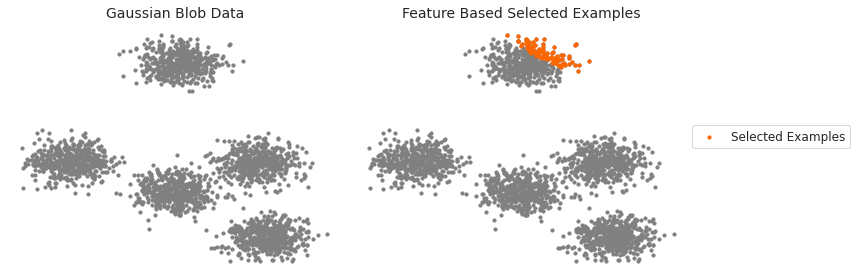

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Gaussian Blob Data", fontsize=14)
plt.scatter(*X.T, color='0.5', s=10)
plt.axis('off')

plt.subplot(122)
plt.title("Feature Based Selected Examples", fontsize=14)
plt.scatter(*X.T, color='0.5', s=10)
plt.scatter(*X[selector.ranking].T, color='#FF6600', s=10, label="Selected Examples")
plt.axis('off')
plt.legend(loc=(1.01, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

Oops. That doesn't look like a representative subset.

Does this mean that feature-based functions cannot work in settings where the data doesn't have the same semantics as our assumptions? No! We just need to engineer features that do follow those semantics.

### Feature Engineering for Feature-based Functions: Gaussian Mixture Models

Potentially, one of the most straightforward ways to transform this Gaussian data would be to, first, apply a Gaussian mixture model to it, and second, use the posterior probabilities from that model as the features. Basically, instead of applying submodular optimization to the original feature values themselves, we apply them to the predicted class probabilities from the mixture model. These probabilities have all the properties that we would like: (1) because they are between zero and one they must be non-negative, (2) a higher value means an enrichment for that feature, i.e., a higher probability means an enrichment for class membership from that class.

Using the `GaussianMixture` object below, transform the above data from in `X` from the original feature values into the posterior probabilities. Because the data was generated from five clusters, your mixture should have five components. If done correctly, the resulting shape should be `(2500, 5)`.

In [25]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(5)
X_posteriors = model.fit(X).predict_proba(X)
X_posteriors.shape

(2500, 5)

In [26]:
X_posteriors[0]

array([9.63580953e-07, 2.80455031e-60, 9.99999033e-01, 3.36573247e-09,
       6.21059074e-29])

Now, apply a feature-based selector as you've done in the past.

In [27]:
selector = FeatureBasedSelection(n_samples=100)
selector.fit(X_posteriors)

Now, let's plot the mixture centroids as well as the selected examples.

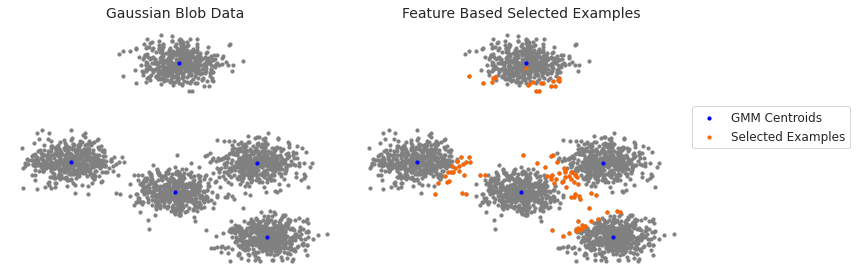

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Gaussian Blob Data", fontsize=14)
plt.scatter(*X.T, color='0.5', s=10)
plt.scatter(*model.means_.T, color='b', s=10)
plt.axis('off')

plt.subplot(122)
plt.title("Feature Based Selected Examples", fontsize=14)
plt.scatter(*X.T, color='0.5', s=10)
plt.scatter(*model.means_.T, color='b', s=10, label="GMM Centroids")
plt.scatter(*X[selector.ranking].T, color='#FF6600', s=10, label="Selected Examples")
plt.axis('off')
plt.legend(loc=(1.01, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

Does this look like what you might expect?

If not, think more closely about the feature-based function and the data here. The sum of each example should be equal to one, so there are no examples that have a higher coverage of the feature space than other examples. However, the feature-based function includes a saturation function that diminishes the benefit of high values in one feature versus spreading them out across several features. Combined, these facts mean that the method will always try to choose examples that are split between multiple classes. Put another way, `numpy.sqrt([0.5, 0.5]).sum() = 1.414` is larger than `numpy.sqrt([1.0, 0]).sum() = 1.0`.

Regardless of the explanation, this isn't exactly what we were expecting. What we'd like to do is have a way that our feature-based function can select examples near the middle of each cluster without needing cluster labels. The problem with using the posteriors, which are normalized to sum to 1, is that examples that are purest for a particular cluster are not the ones closest to the centroid but rather the ones that are on the other side of the centroid as all the other centroids. 

What does that mean? Well, let's use a simple trick to try to pick out the purest examples from each cluster. First, we need to transform these values such that values near one become bigger, so that purity is valued higher, but values near zero remain the same. We can use an `arctanh` function for that, but you should try out any other function you'd like to see the effects. Below is an example `arctanh` function.

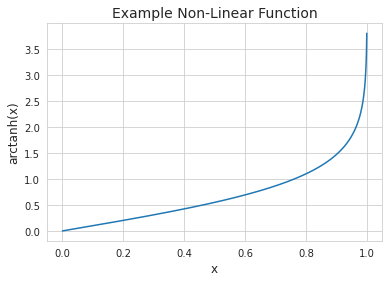

In [29]:
x = numpy.arange(0, 1, 0.001)
plt.plot(x, numpy.arctanh(x))
plt.title("Example Non-Linear Function", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("arctanh(x)", fontsize=12)
plt.show()

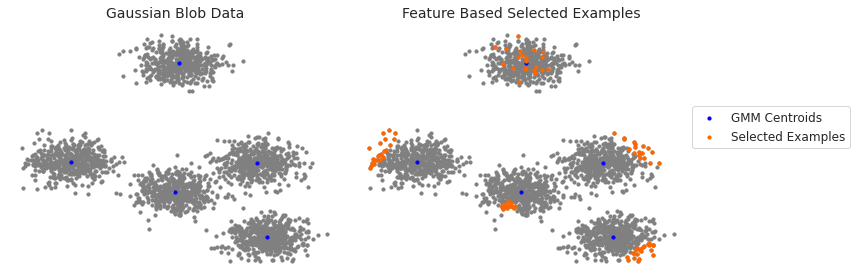

In [30]:
X_arctanh = numpy.arctanh(X_posteriors - 1e-12) + 1e-12

selector = FeatureBasedSelection(n_samples=100)
selector.fit(X_arctanh)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Gaussian Blob Data", fontsize=14)
plt.scatter(*X.T, color='0.5', s=10)
plt.scatter(*model.means_.T, color='b', s=10)
plt.axis('off')

plt.subplot(122)
plt.title("Feature Based Selected Examples", fontsize=14)
plt.scatter(*X.T, color='0.5', s=10)
plt.scatter(*model.means_.T, color='b', s=10, label="GMM Centroids")
plt.scatter(*X[selector.ranking].T, color='#FF6600', s=10, label="Selected Examples")
plt.axis('off')
plt.legend(loc=(1.01, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

We can see some interesting trends here. Unlike the previous plot where all the chosen examples were near boundaries, most of the chosen examples are on very edge of the convex hull. A notable exception, however, is the top cluster. This is likely because the top cluster is so far away from the others that any example in it is considered "pure." 

Finally, let's get to the expected behavior. We would like to design a transformation such that our selection chooses elements that are neat representations of each cluster individually. We saw previously that using the normalized posterior probabilities can be an issue because the normalization process encourages the chosen examples to be far away from the other centroids, rather than close to any particular centroid. If we get rid of that normalization process and instead use the raw probabilities that each example belongs to a particular mixture component, we can get around this.

In the cell below, use the `multivariate_normal` method from scipy to calculate an array of probabilities for each example under each mixture component. Hint: you will need to do this separately for each component as part of a loop. Make sure that your final output is of shape `(n_samples, 5)`.

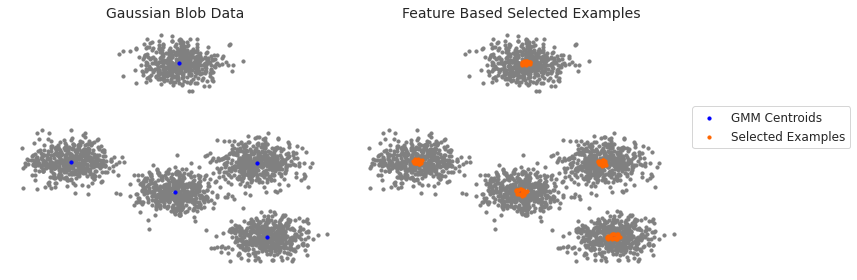

In [36]:
from scipy.stats import multivariate_normal

X_probs = numpy.array([multivariate_normal.pdf(X, model.means_[i], model.covariances_[i]) for i in range(5)]).T

selector = FeatureBasedSelection(n_samples=100)
selector.fit(X_probs)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Gaussian Blob Data", fontsize=14)
plt.scatter(*X.T, color='0.5', s=10)
plt.scatter(*model.means_.T, color='b', s=10)
plt.axis('off')

plt.subplot(122)
plt.title("Feature Based Selected Examples", fontsize=14)
plt.scatter(*X.T, color='0.5', s=10)
plt.scatter(*model.means_.T, color='b', s=10, label="GMM Centroids")
plt.scatter(*X[selector.ranking].T, color='#FF6600', s=10, label="Selected Examples")
plt.axis('off')
plt.legend(loc=(1.01, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

If you've done this correctly, you'll notice that all of the chosen examples are near the centroids of the clusters. 

At this point, you might be wondering "why do I need submodular optimization to do this?" because you can just take the examples closest to centroids. The answer is two-fold: first, submodular optimization can be applied to any type of transformation where it may not be obvious how to do it by hand. Second, submodular optimization automatically balances the number of examples chosen per centroid based on their distance. This isn't a particularly complicated task here where all of the clusters are distinct, but consider this example:

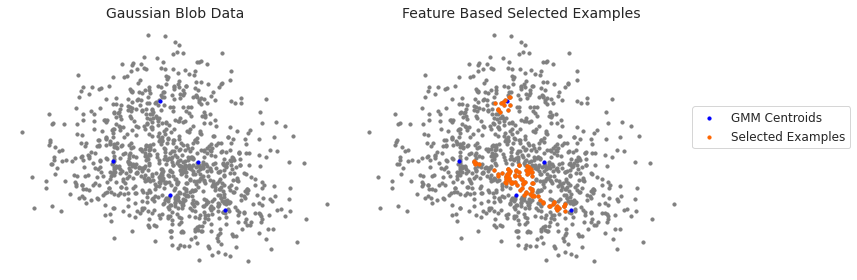

In [37]:
numpy.random.seed(0)
centers = numpy.random.normal(100, 4, (5, 2))
X2, _ = make_blobs(n_samples=1000, n_features=2, centers=centers, cluster_std=3, random_state=0)

model2 = GaussianMixture(5, random_state=0).fit(X2)
X_probs = numpy.array([multivariate_normal.pdf(X2, model2.means_[i], model2.covariances_[i]) for i in range(5)]).T

selector = FeatureBasedSelection(n_samples=100)
selector.fit(X_probs)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Gaussian Blob Data", fontsize=14)
plt.scatter(*X2.T, color='0.5', s=10)
plt.scatter(*model2.means_.T, color='b', s=10)
plt.axis('off')

plt.subplot(122)
plt.title("Feature Based Selected Examples", fontsize=14)
plt.scatter(*X2.T, color='0.5', s=10)
plt.scatter(*model2.means_.T, color='b', s=10, label="GMM Centroids")
plt.scatter(*X2[selector.ranking].T, color='#FF6600', s=10, label="Selected Examples")
plt.axis('off')
plt.legend(loc=(1.01, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

Here, the selected examples are close to one of the centroids, which is arguably in low-data areas and probably have a smaller variance. Because the other four centroids are in data-richer areas their variances likely overlap significantly, and so the chosen examples are in the central region between the three of them. Simply choosing the points near the centroid would not give the same results. This isn't to say that this is always exactly the most representative set from this data, just that this is a case where submodular optimization will provide different results from a simpler approach.

## Facility Location Selection

An alternative to feature-based functions are graph-based functions. These functions operate on a similarity matrix (note: a similarity matrix is the inverse of a distance matrix, where the most similar elements in a distance matrix have a pairwise value of zero whereas the most distant elements in a similarity matrix have a pairwise value of zero) instead of the feature values directly. Graph-based functions are generally more versatile than feature-based ones because any featurization of data can be converted into a similarity graph by calculating the Euclidean distance or correlation between examples, but data types that are inherently graphs can also be operated on. 

A specific graph-based function is the facility location function, which has been used in the past to literally locate new facilities. In this setting, one wants to identify the next location that would serve the most people that are currently underserved without having to move any of the previous locations. The facility location function takes the following form: 

\begin{equation}
f(X, V) = \sum\limits_{v \in V} \max\limits_{x \in X} \phi(x, v)
\end{equation}
where $x$ is a selected example $X$ is the set of already selected examples, $v$ is an unselected example, $V$ is the set of unselected examples, and $\phi$ is a similarity function that either returns an entry in a pre-defined similarity matrix or calculates the similarity between two examples.

A challenge with using graph-based functions is that the similarity matrix has to be calculated and stored in memory for efficient computation, which can be challenging for massive data sets. However, it is more versatile because similarities can be calculated that are more informative than simple featurizations.

### Greedy Version of K-means Clustering

A simple way to think about using submodular optimization to optimize a facility location function is that it is a greedy version of k-medoids clustering. As a refresher, k-medoids clustering is similar to k-means except that the cluster centroids must be examples from the training set. It is similar to the difference between calculating the mean and calculating the median. Submodular optimization on a facility location function involves iteratively choosing the example that best explains the previously explained examples, i.e., that maximizes the increase in similarity between all of the examples and all of the chosen examples.

What does that look like in practice? Implement a facility location selection object to choose 50 examples. You'll notice that, despite being a graph-based function, you can still pass in a feature matrix and it will automatically calculate a similarity graph from that.

In [ ]:
from apricot import FacilityLocationSelection

selector = ...

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Gaussian Blob Data", fontsize=14)
plt.scatter(*X.T, color='0.7', s=10)
plt.scatter(*model.means_.T, color='b', s=10)
plt.axis('off')

plt.subplot(122)
plt.title("Facility Location Selected Examples", fontsize=14)
plt.scatter(*X.T, color='0.7', s=10)
plt.scatter(*model.means_.T, color='b', s=10, label="GMM Centroids")
plt.scatter(*X[selector.ranking].T, color='#FF6600', s=10, label="Selected Examples")
plt.axis('off')
plt.legend(loc=(1.01, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

The selected examples should appear to be fairly uniformly distributed across the space. If you're noticing a concentration of points anywhere, you may have incorrectly implemented something.

To get a sense for the selection process, let's visualize the iterative process of selecting examples.

In [ ]:
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title("{} Selections".format(i+1), fontsize=14)
    plt.scatter(*X.T, color='0.7', s=10)
    
    if i > 0:
        plt.scatter(*X[selector.ranking[:i]].T, color='0.1', s=10, label="Selected Examples")
    
    plt.scatter(*X[selector.ranking[i]].T, color='#FF6600', s=10, label="Next Selection")
    plt.axis('off')

plt.legend(loc=(1.01, 0.5), fontsize=12)
plt.tight_layout()
plt.show()

You'll notice that the first example comes from around the center of the data set. As a greedy approach, the optimizer is trying to find the single best example without knowing if it will be able to choose future ones. Then, the second example comes from an underrepresented area, etc.

### Digits Data Set

Now, let's apply facility location functions to choosing data for machine learning. A constraint of the feature-based functions is that they only work when the features follow a particular set of semantics. Although there are powerful approaches for transforming features into new features that follow those semantics, it's also nice to not have to do anything fancy to get a good set of items. A good example of data where the assumptions of feature-based functions don't work out of the box are those that involve images.

Let's download a reduced version of the digits data set and try training a machine learning model using selected subsets or random subsets, as we did before.

In [ ]:
from sklearn.datasets import load_digits

random.seed(0)

X, y = load_digits(return_X_y=True)

idxs = numpy.arange(X.shape[0])
numpy.random.shuffle(idxs)

X = X[idxs]
y = y[idxs]

X_train, y_train = X[:1000], y[:1000]
X_test, y_test = X[1000:], y[1000:]

Now, impelment a facility location function to choose 1000 examples and a feature-based function to also choose 1000 examples, for comparison.

In [ ]:
fl_selector = ...

fb_selector = ...

Let's see how the subsets selected using facility location fare against those selected using random selection or feature-based selection.

In [ ]:
numpy.random.seed(0)

model = SGDClassifier(random_state=0)
counts = numpy.arange(10, 1001, 10)

random_idxs = numpy.array([numpy.random.choice(X_train.shape[0], replace=False, size=1000) for i in range(10)])
random_accuracies, fl_accuracies, fb_accuracies = [], [], []

for count in tqdm(counts):
    #
    idxs = ...

    y_hat = model.predict(X_test)
    acc = (y_hat == y_test).mean()
    fl_accuracies.append(acc)

    #
    idxs = ...

    y_hat = model.predict(X_test)
    acc = (y_hat == y_test).mean()
    fb_accuracies.append(acc)
    
    accs = []
    for i in range(10):
        r_idxs = random_idxs[i, :count]
        ...
        
        y_hat = model.predict(X_test)
        acc = (y_hat == y_test).mean()
        accs.append(acc)
    
    random_accuracies.append(accs)

In [ ]:
plt.title("Reduced MNIST Classification", fontsize=14)
plt.plot(counts, numpy.mean(random_accuracies, axis=1), color='0.5', linewidth=2, label="Random")
plt.plot(counts, fl_accuracies, color='#FF6600', linewidth=2, label="Facility Location Optimization")
plt.plot(counts, fb_accuracies, color='g', linewidth=2, label="Feature-Based Optimization")

plt.xlabel("# Chosen Examples", fontsize=12)
plt.ylabel("Classification Accuracy")
plt.legend(loc=4, fontsize=12)

seaborn.despine()
plt.tight_layout()
plt.show()

Looks like the facility location function achieves high accuracy with only a small number of examples! Using only 40 examples achieves almost 90% accuracy, whereas it takes almost 200 randomly selected examples to get hat performance on average. 